# Face Recognition - Predicting Celebrity Faces

### Import Libraries

In [314]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import re
import glob

import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

from IPython.display import Image, display
from PIL import Image

%matplotlib inline

## Evaluation

### Load in Preprocessed Data

In [339]:
#grab images from local directory, where all the image folders are kept
image_dir = os.path.join('./Data/images')

In [340]:
#function to grab only the name of folders without number
def subject_names(data_folder_path):
    base_dir = os.listdir(data_folder_path)
    class_names = []
    
    #loop throough each folder path and add to list
    for dir_name in sorted(base_dir):
        #to ignore system files (.DS_Store)
        if dir_name.startswith("."):
            continue;
        new_name = re.sub('[0-9]', '', dir_name)
        class_names.append(new_name)
        
    return class_names

In [341]:
#will use class_names later for predictions
class_names = subject_names(image_dir)
class_names

['Anne_Hathaway',
 'Ben',
 'Dave_Chappelle',
 'Elizabeth_Olsen',
 'Jessica_Alba',
 'Mark',
 'Zac_Efron']

In [342]:
# this function is to just get the numbers after the file name
def get_numbers(dir_name):
    digits = re.compile(r'\d+')
    digit = [int(x) for x in digits.findall(dir_name)]
    
    return digit


#just to test out grabbing each label number so that I can implement into the next function
def label_number(data_folder_path):
    base_dir = os.listdir(data_folder_path)
    labels = []
    
    for dir_name in base_dir:
        #ignore system files
        if dir_name.startswith("."):
            continue;
        label = get_numbers(dir_name)
        labels.append(label)
        
    return labels

In [343]:
#see if it works
labels = label_number(image_dir)
labels

[[0], [3], [6], [2], [4], [5], [1]]

In [344]:
#function to prepare images for model
def prepare_training_data(data_folder_path):
    base_dir = os.listdir(data_folder_path)
    
    #list to hold all subject faces
    faces = []
    #list to hold labels for all subjects
    labels = []
    
    #let's go through each directory and read images within it
    for dir_name in base_dir:
        
        #extract label number of subject from dir_name
        if dir_name.startswith("."):
            continue;
        label = get_numbers(dir_name)
        
        #build path of directory containin images for current subject subject
        subject_dir_path = data_folder_path + "/" + dir_name
        
        #get the images names that are inside the given subject directory
        subject_images_names = os.listdir(subject_dir_path)

        #go through each image name, read image, 
        for image_name in subject_images_names:
          
            #build image path
            image_path = subject_dir_path + "/" + image_name

            #read image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            
            if image is not None:
                faces.append(image)
                labels.append(label)
    
    return faces, labels

In [345]:
#execute function with dataset
faces, labels = prepare_training_data(image_dir)

In [346]:
len(faces)

3004

In [347]:
#reshape the images to proper format
reshaped_faces = np.concatenate(faces, axis=0).reshape(len(faces),175,175,3)

In [348]:
reshaped_faces.shape

(3004, 175, 175, 3)

In [349]:
#change to array
reshaped_labels = np.vstack(labels)

In [351]:
#to categorical target
y_cat = to_categorical(reshaped_labels, num_classes=7)

In [352]:
#number of classes
y_cat.shape[1]

7

In [353]:
#normalize and set type to float for X and y
X = reshaped_faces.astype('float32') / 255.0
y = y_cat.astype('float32') / 255.0

In [354]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

## Load Model

In [372]:
#load model that was saved 
best_model = load_model('2_batch20.h5')

In [373]:
#evaluate the model
best_model.evaluate(X_test, y_test)

601/601 [==============================] - 22s 36ms/step


[0.0003113714371470443, 0.9816971704884496]

This was the best model that I produced with a loss of .0003 and an accuracy of 0.982. This is successful compared to some of the other studies I have seen and is probably due to having more images to train with. Other studies only work with 10 to 100 images where I had around 300-400 images to train on. 

In [364]:
#function to detect faces in image
def detect_face(img):
    haar_face_cascade = cv2.CascadeClassifier('./Data/test_images/haarcascade_frontalface_alt.xml')
    face = haar_face_cascade.detectMultiScale(img, scaleFactor=1.09, minNeighbors=5)
    
    (x, y, w, h) = face[0]
    
    return img[y:y+w, x:x+h], face[0]

#function to draw rectangle around face
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

#function to place a text of the predicted name
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 3,cv2.LINE_AA)

In [365]:
#function to predict the new images
def predict(test_img):
    #copy original image 
    img = test_img.copy()
    #detect face, set face and rectangle value
    face, rect = detect_face(img)
    #resize the image of the faze to fit my model dimensions
    face_resized_img = cv2.resize(face, (175,175), interpolation = cv2.INTER_AREA)
    
    #make prediction on resized image and set it a label value
    label = best_model.predict_classes(face_resized_img.reshape(1,175,175,3))
    #grab the name from the list of class names from predicted label value
    label_name = class_names[label[0]]
    
    #draw rectangle over the face
    draw_rectangle(img, rect)
    #draw text of the predicted name
    draw_text(img, label_name, rect[0], rect[1]-5)
    
    return img

In [366]:
#convert color to RGB because OpenCV uses BGR
def convert_color(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return image

In [367]:
#function to load in data as array
def load_images_from_folder(folder):
    images = []
    for f in glob.iglob(folder):
        images.append(np.asarray(Image.open(f)))
    images = np.array(images)
    return images

In [368]:
#load in test images
test_images = load_images_from_folder(folder='./Data/test_images/*.jpg')

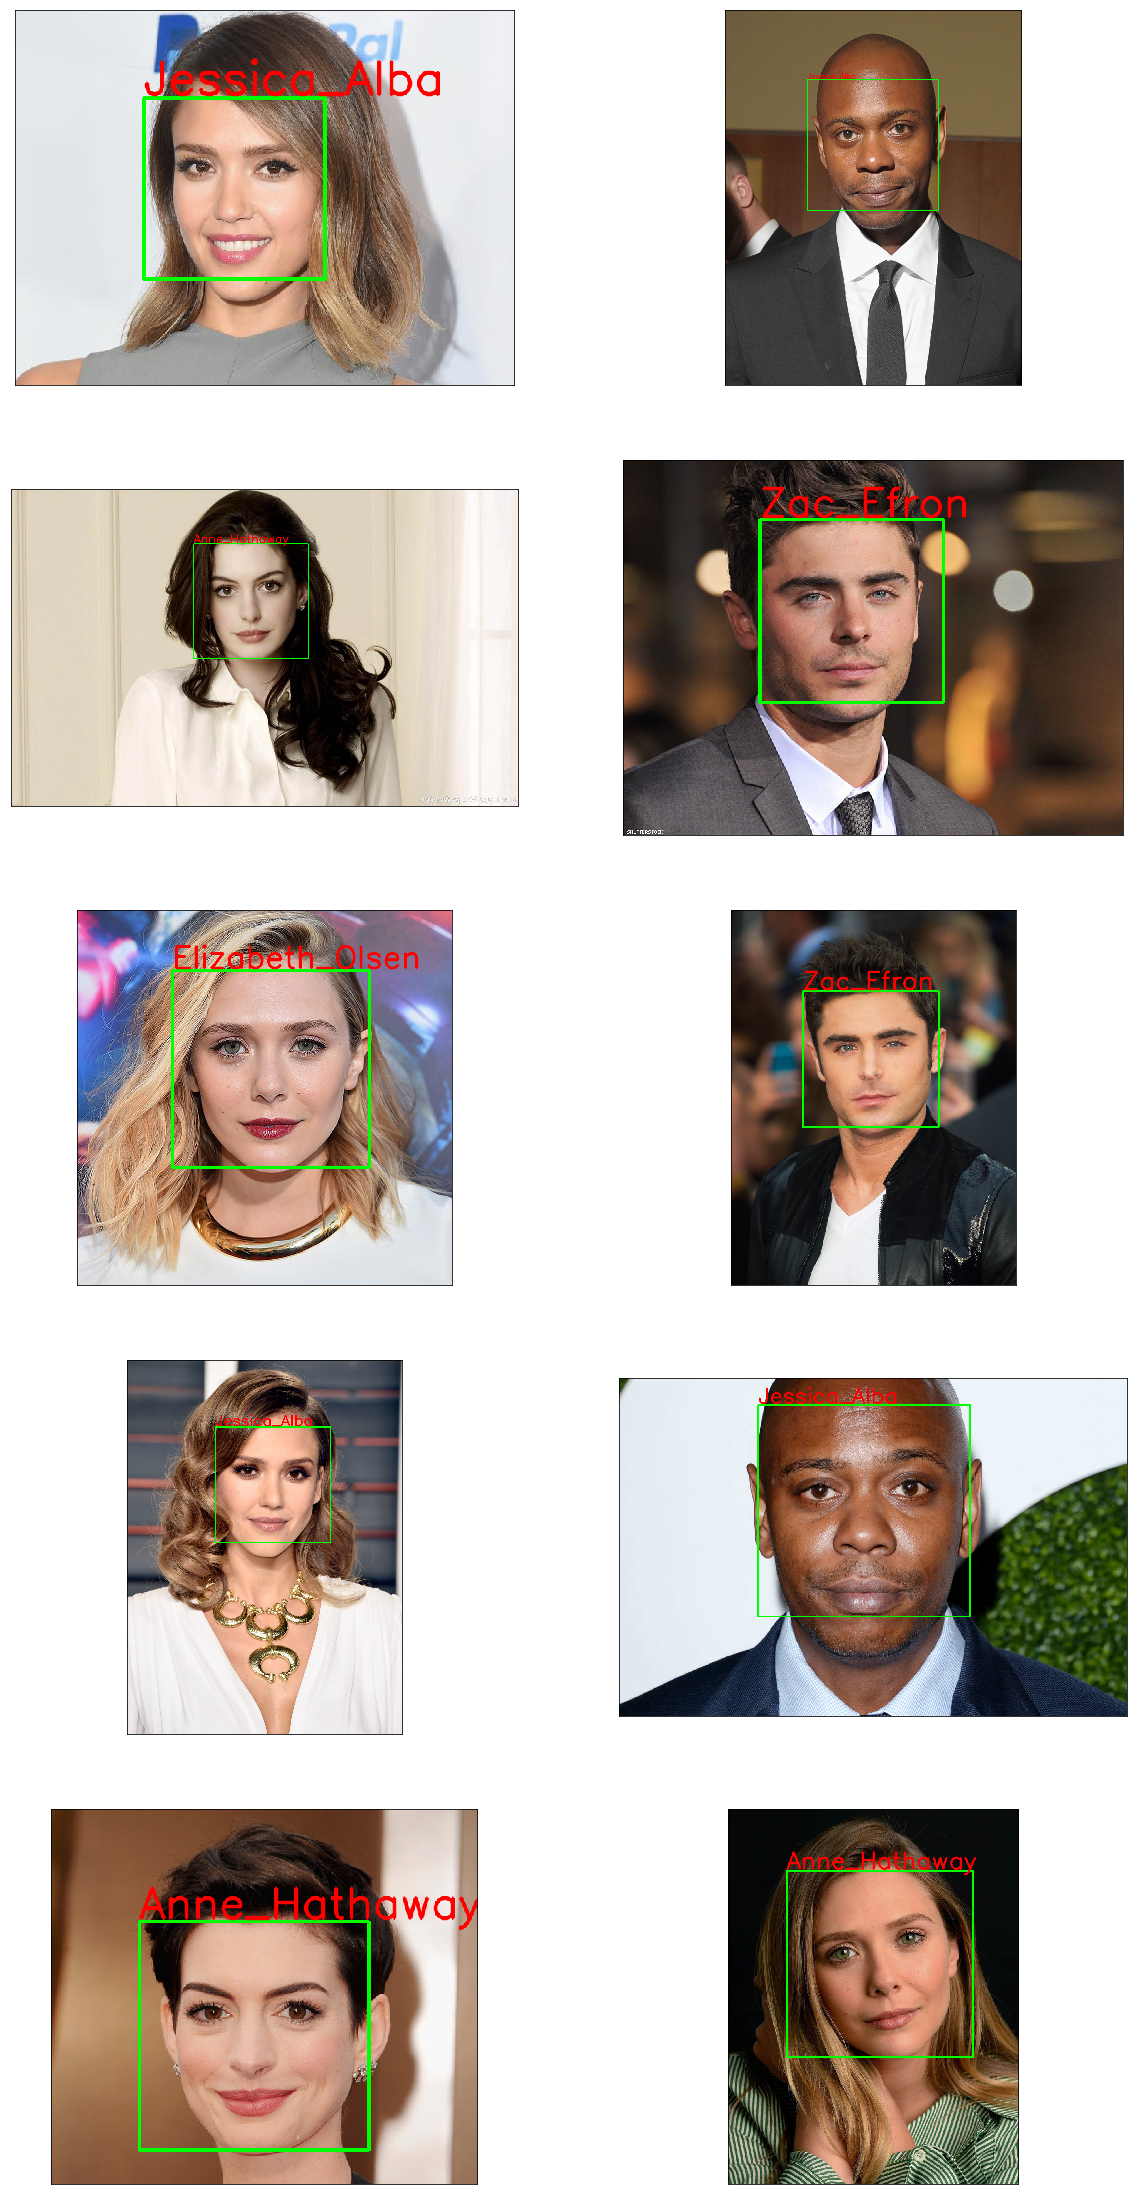

In [374]:
#plot out predictions with predict function
fig = plt.figure(figsize=(20,40))
for i, image in enumerate(test_images[:10]):
    fig.add_subplot(5, 2, 1+i)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(predict(image));

Although my model had such high accuracy, it still makes a few false predictions. When I run the model through a webcam script to make real time predictions, it also accurately predicts the faces most of the time. I have tried fine tuning my model parameters multiple times but it still seems to be overfitting. I believe that I would need to gather at least double the amount of data I currently have, if not more, to make it more accurate. 

In addition, when adding more people to the model, the performance drops dramatically. This furthers my belief that there needs to be a substantial amount of face images so that the model can better learn the unique features of each individual. I really learned that the more clean data you have the better a face recognition model will perform. Thus, in order to implement such model in the real world, we would need to continuously feed the model with more and more images for better classification. 